In [2]:
import os
from math import pi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
!pwd

/c/Users/power/OneDrive/Desktop/mod-1-proj


In [3]:
#load files
movie_budget=pd.read_csv("zippedData/tn.movie_budgets.csv.gz") #budget and gross revenue of movies
spy_monthly=pd.read_csv("zippedData/SPY.csv") #stock market monthly returns
GDP=pd.read_csv('zippedData/GDP_DEF.csv') #GDP deflator to adjust numbers by inflation

In [4]:
#dealing with dates
movie_budget.rename(columns={"movie":"title"}, inplace=True)
movie_budget['release_date']=pd.to_datetime(movie_budget['release_date'])
#Forward all the dates to the beginning of their next months
movie_budget['view_date']=movie_budget.release_date+pd.offsets.MonthBegin(1)
movie_budget['year']=movie_budget['view_date'].dt.year
#trim off 2019
movie_budget=movie_budget[movie_budget['year']<=2018]

In [5]:
#spy_monthly contains dates only beyond 2000, by default the merged file has a time frame between 2000 to 2018
spy_monthly['view_date']=pd.to_datetime(spy_monthly['Date'])
spy_monthly.sort_values(["view_date"],inplace=True)
#calculate monthly returns
spy_monthly['percent_return_month']=(spy_monthly['Adj Close'].shift(-1)-spy_monthly['Adj Close'])/spy_monthly['Adj Close']*100
#look at the average of past two month stock market performance
spy_monthly['percent_return_rolling']=spy_monthly.percent_return_month.rolling(2).mean()
#bin the performance into Low, Medium and High for visualization
spy_monthly['market_condition']=pd.cut(spy_monthly['percent_return_rolling'], bins=3, labels=['Low','Medium','High'])

In [6]:
#Merge the files: budget files with the stock market and also the GDP
#for inflation adjustment
movie_budget=movie_budget.merge(spy_monthly[['view_date','percent_return_month','percent_return_rolling',"market_condition"]], on="view_date")
movie_budget=movie_budget.merge(GDP, on='year')

In [7]:
#change all the strings to numerical values for gross revenue and budget
to_replace_list=["domestic_gross","worldwide_gross","production_budget"]
for i in to_replace_list:
    movie_budget[i]=movie_budget[i].str.replace(r"$","")
    movie_budget[i]=movie_budget[i].str.replace(r",","")

In [8]:
#inflation adjustment: Here movies are nondurable goods
for i in to_replace_list:
    movie_budget[i]=movie_budget[i].astype("int64")/movie_budget['nondurable_goods_expenditure']*100

In [9]:
#measure overall, domestic and foreign profitability
movie_budget['domestic_profit']=(movie_budget['domestic_gross']-movie_budget['production_budget'])
movie_budget['foreign_profit']=(movie_budget['worldwide_gross']-movie_budget['domestic_gross'])
movie_budget['profit_margin']=(movie_budget['worldwide_gross']-movie_budget['production_budget'])/(movie_budget['production_budget'])*100
movie_budget['domestic_margin']=(movie_budget['domestic_profit'])/(movie_budget['production_budget'])*100
movie_budget['foreign_margin']=(movie_budget['foreign_profit'])/(movie_budget['production_budget'])*100

In [10]:
#do a percentile rank for movies' budget within a year
#bin the rank into two halfs:
#  0--Median belongs to Independent Movie bin
#  Median--100 belongs to Mass Production Movie bin
movie_budget['production_budget_rank']=movie_budget.groupby(['year'])\
                                        ['production_budget'].rank(pct=True)
movie_budget['budget_size']=pd.cut(movie_budget['production_budget_rank'],\
                                   bins=2, labels=["Independent","Mass Production"])
# create a competition measure: around the movie release date
# compute how many movies there are in theater as well
movie_budget['count']=movie_budget.groupby(['view_date'])['title'].transform("count")
# for visualization, again, we bin the competition measure to 4 categories
movie_budget['competition_size']=pd.cut(movie_budget['count'], bins=4, \
                                   labels=['Low','Moderately Low','Moderately High','High'])

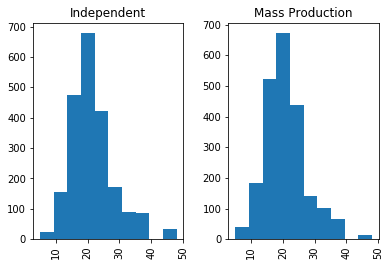

In [11]:
movie_budget.hist('count',by="budget_size")
#the end of the file editing, now pickle the file
movie_budget.to_pickle(r"merged_file.pickle")

<Figure size 432x288 with 0 Axes>

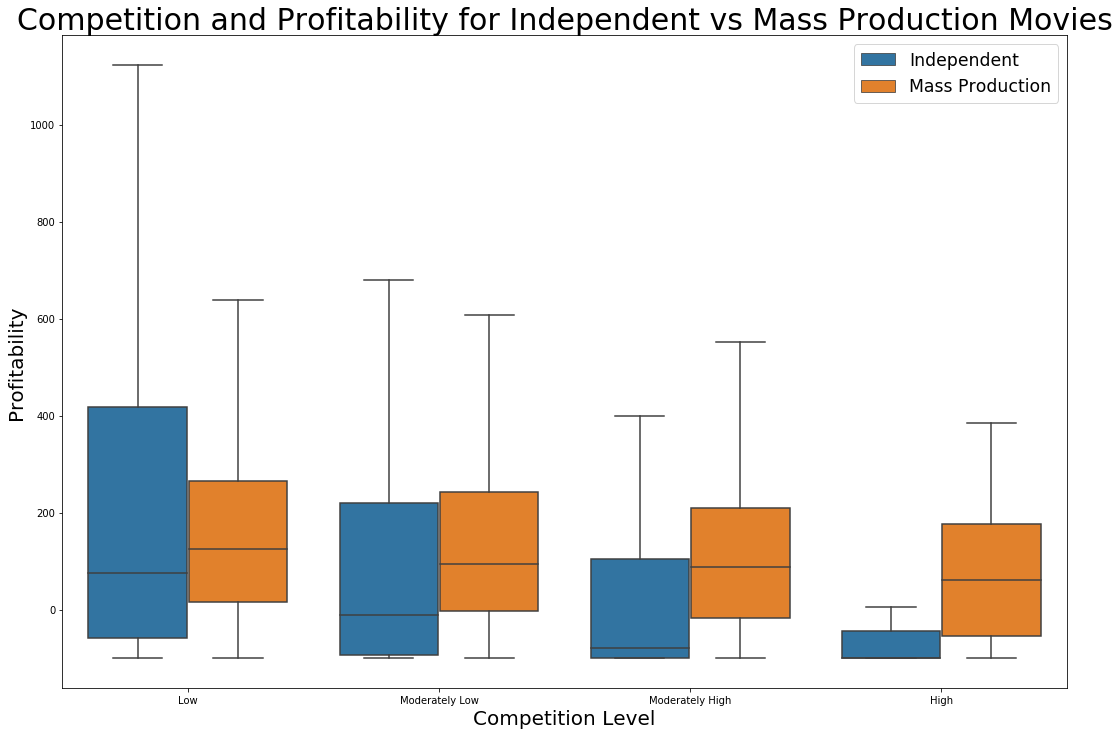

In [17]:
#first plot: movie competition and profitability
plt.clf()
plt.figure(figsize=(18, 12))
sns.boxplot('competition_size','profit_margin', data=movie_budget,\
            hue="budget_size", showfliers=False)
plt.xlabel("Competition Level", size=20)
plt.ylabel("Profitability", size=20)
plt.legend(fontsize="xx-large")
plt.title("Competition and Profitability for Independent \
                vs Mass Production Movies", size=30)
plt.savefig("competition and profitability.png")
plt.show()

<Figure size 432x288 with 0 Axes>

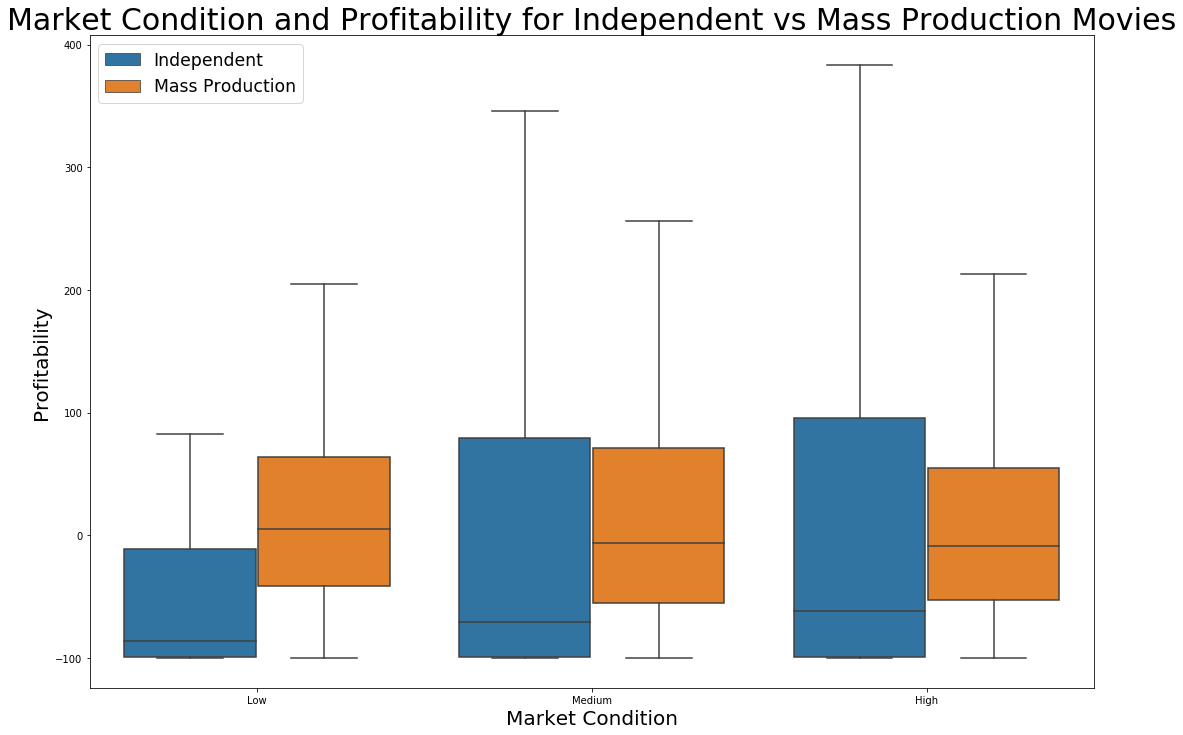

In [13]:
#second plot: market condition and profitability
plt.clf()
plt.figure(figsize=(18, 12))
sns.boxplot('market_condition','domestic_margin', data=movie_budget, hue="budget_size", showfliers=False)
plt.xlabel("Market Condition", size=20)
plt.ylabel("Profitability", size=20)
plt.legend(fontsize="xx-large")
plt.title("Market Condition and Profitability for Independent vs Mass Production Movies", size=30)
plt.savefig("market and profitability.png")

In [14]:
#for visualization, we aggregate the movies by the month they 
#are released. For labeling, we need January, Feburary, ... 
#in stead of 01, 02, ... Differentiate month with month_num
movie_budget['month']=movie_budget.view_date.dt.strftime("%B")
movie_budget['month_num']=movie_budget.view_date.dt.month

# since we are only focusing on the independent movies (defined by budget size),
# to show how seasonality affects profitability, we only use independent movies.
# we aggregation by 1. count (number of movies). 2. average profitability 3. a label 
# that we can sort on to the month level.
budget_movie_agg=movie_budget[movie_budget['budget_size']=="Independent"]\
    .groupby("month").agg({"title":"count",\
    "profit_margin":"mean","month_num":"min"}).reset_index()
budget_movie_agg.sort_values("month_num", inplace=True)

In [15]:
print(budget_movie_agg)

        month  title  profit_margin  month_num
4     January    270     109.331524          1
3    February    132     333.722560          2
7       March    143     252.676782          3
0       April    184     215.428935          4
8         May    195     293.424402          5
6        June    141     548.169141          6
5        July    151     308.133578          7
1      August    144     535.288684          8
11  September    170     361.312198          9
10    October    223     423.252765         10
9    November    261     342.702922         11
2    December    126     247.542780         12


<Figure size 432x288 with 0 Axes>

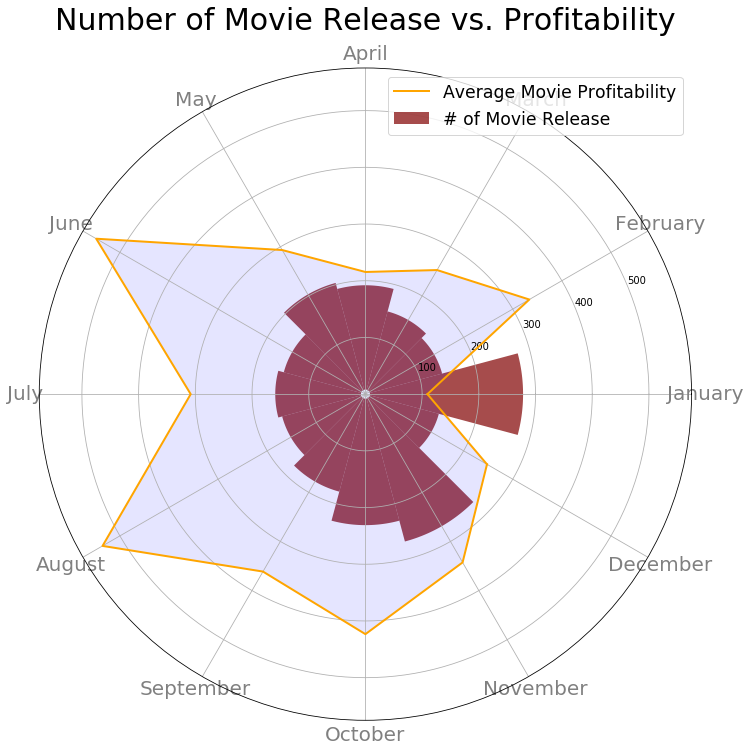

In [16]:
#third plot: independent movie seaonality and profitability
plt.clf()
plt.figure(figsize=(18,12))
#some parameters for the graph
bottom = 8
max_height = 4
N=12
theta = [n / float(N) * 2 * pi for n in range(N)]
width = (2*pi) / N

#data source
radii=budget_movie_agg["title"].to_list()
radiii=budget_movie_agg["profit_margin"].to_list()
#polar plot
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom, label='# of Movie Release')
ax.plot(theta, radiii, linewidth=2, linestyle='solid',color="orange", label='Average Movie Profitability')
ax.plot([theta[-1],theta[0]], [radiii[-1],radiii[0]], linewidth=2, linestyle='solid', color="orange")
plt.xticks(theta, budget_movie_agg["month"], color='grey', size=20)
plt.fill(theta, radiii, 'b', alpha=0.1)

# custom colors and transparency
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.7)

ax.legend(fontsize="xx-large")
plt.title("Number of Movie Release vs. Profitability", size=30)
plt.savefig("release_profitability_month.png")